In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import fft

# from nalger_helper_functions import conforming_grid_convolution, conforming_box, make_regular_grid, plot_rectangle
from nalger_helper_functions import *

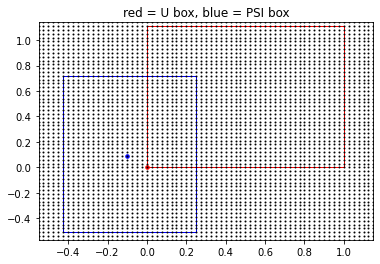

In [2]:
hh = np.array([0.025, 0.03])

U_centerpoint = np.zeros(2)
min_U, max_U, U_shape = conforming_box(np.array([0., 0.]), np.array([1., 1.1]), U_centerpoint, hh)

PSI_centerpoint = np.round(np.array([-0.1, 0.1]) / hh) * hh
min_PSI, max_PSI, PSI_shape = conforming_box(np.array([-0.4, -0.5]), np.array([0.23, 0.7]), PSI_centerpoint, hh)

min_plot, max_plot, plot_shape = conforming_box(np.min([min_U, min_PSI])-hh, np.max([max_U, max_PSI])+hh, 
                                                np.zeros(2), hh)

d = len(min_PSI)

_, (XPSI, YPSI) = make_regular_grid(min_PSI, max_PSI, PSI_shape)
_, (XU, YU) = make_regular_grid(min_U, max_U, U_shape)
_, (X, Y) = make_regular_grid(min_plot, max_plot, plot_shape)

plt.figure()

r1 = plot_rectangle(min_U, max_U, edgecolor='r')
plt.plot(U_centerpoint[0], U_centerpoint[1], '.r', markersize=7)

r2 = plot_rectangle(min_PSI, max_PSI, edgecolor='b')
plt.plot(PSI_centerpoint[0], PSI_centerpoint[1], '.b', markersize=7)

plt.plot(X[:], Y[:], '.k', markersize=2)

plt.xlim(min_plot[0], max_plot[0])
plt.ylim(min_plot[1], max_plot[1])

plt.title('red = U box, blue = PSI box')

plt.show()

In [3]:
def make_2D_grid_gaussian(mu, Sigma, X, Y):
    d = len(X.shape)
    C = np.power(2 * np.pi, -d/2.) * np.power(np.linalg.det(Sigma), -1./2.)
    
    zz = np.vstack([X.reshape(-1), Y.reshape(-1)]) - mu.reshape((-1,1))
    F = C * np.exp(-0.5 * np.sum(zz * np.linalg.solve(Sigma, zz), axis=0).reshape(-1)).reshape(X.shape)
    return F

/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:128: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.data)


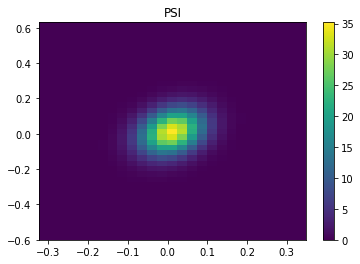

In [4]:
mu = PSI_centerpoint
Sigma = np.array([[0.004, 0.0015], 
                  [0.0015, 0.011]])*0.7

PSI_data = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI)
# PSI_data = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI) * np.sin(10*XPSI + 8*YPSI)

PSI = BoxFunction(min_PSI, max_PSI, PSI_data).translate(-PSI_centerpoint)

PSI.plot(title='PSI')

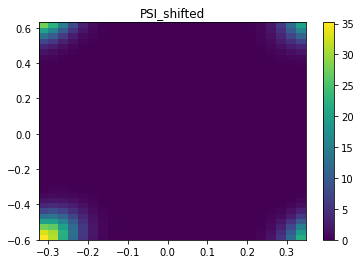

In [5]:
PSI_zeropoint_inds = np.round(-PSI.box_min / PSI.hh).astype(int)

PSI_shifted_data = np.roll(PSI.data, -PSI_zeropoint_inds, axis=np.arange(PSI.ndim))
PSI_shifted = BoxFunction(PSI.box_min, PSI.box_max, PSI_shifted_data)

PSI_shifted.plot(title='PSI_shifted')

In [6]:
def square_root(z, branch_cut_theta):
    "Square root with different branch cut defined by theta parameter."
    #https://flothesof.github.io/branch-cuts-with-square-roots.html
    argument = np.angle(z) # between -pi and +pi
    modulus = np.abs(z)
    argument = np.mod(argument + branch_cut_theta, 2 * np.pi) - branch_cut_theta
    return np.sqrt(modulus) * np.exp(1j * argument / 2)

imag_fraction= 4.6684552806904556e-14


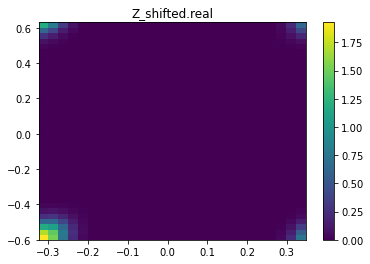

In [7]:
Z_shifted_data = fft.ifft2(square_root(fft.fft2(PSI_shifted.data), 1.0*np.pi))
imag_fraction = np.linalg.norm(Z_shifted_data.imag) / np.linalg.norm(Z_shifted_data)
print('imag_fraction=', imag_fraction)

Z_shifted = BoxFunction(PSI.box_min, PSI.box_max, Z_shifted_data)

Z_shifted.real.plot('Z_shifted.real')

Z.real.norm()= 5.931942407420388
Z.imag.norm()= 0.0


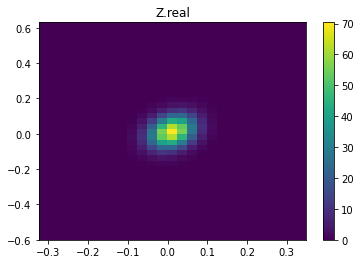

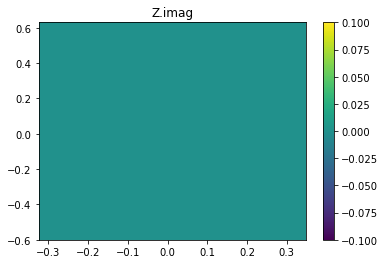

In [8]:
Z_data = np.roll(Z_shifted.data, PSI_zeropoint_inds, axis=np.arange(Z_shifted.ndim)).real

Z = BoxFunction(Z_shifted.box_min, Z_shifted.box_max, Z_data) * (1./np.sqrt(Z_shifted.element_volume))

Z.real.plot(title='Z.real')
Z.imag.plot(title='Z.imag')

Z_real_norm = Z.real.norm()
print('Z.real.norm()=', Z.real.norm())

Z_imag_norm = Z.imag.norm()
print('Z.imag.norm()=', Z.imag.norm())

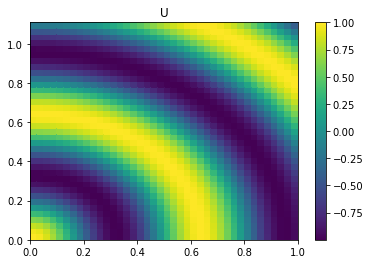

In [9]:
U_data = np.cos(10*np.sqrt(XU**2 + YU**2))

U = BoxFunction(min_U, max_U, U_data).translate(-U_centerpoint)

U.plot(title='U')

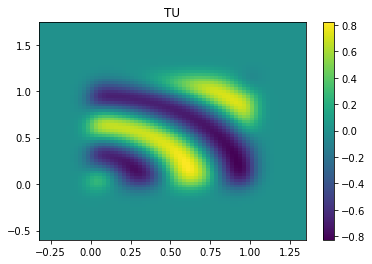

In [10]:
TU = convolve_box_functions(PSI, U)

TU.plot(title='TU')

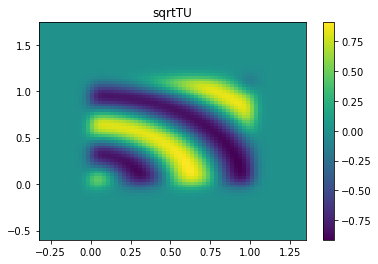

In [11]:
sqrtTU = convolve_box_functions(Z.real, U)

sqrtTU.plot('sqrtTU')

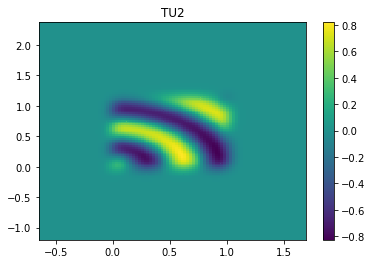

In [12]:
TU2 = convolve_box_functions(Z.real, sqrtTU)

TU2.plot('TU2')

err_sqrt= 2.77285197788109e-07


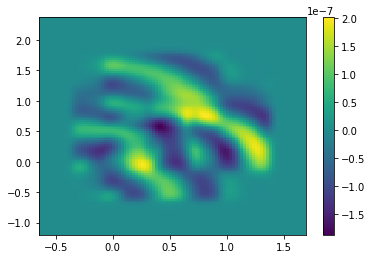

In [13]:
err_sqrt = (TU2 - TU).norm() / TU.norm()
print('err_sqrt=', err_sqrt)

(TU2 - TU).plot()